The **KnnBaseline** performed the best out of all the models for the memory based algorithm. 

**Knn Baseline** perform **slightly better** than the SVD method so we will use that for our model.

## Item to Item Comparisons
There happen to be more movies than a user, so it would be ideal to see if item-based filtering would perform better than the user-based model. Unfortunately, it did not. 

In [17]:
### Train another model but item to item comparison instead ###

sim_pearson = {"name": "pearson", "user_based": False}
knn_baseline_item = knns.KNNBaseline(k = 30, min_k = 4,sim_options=sim_pearson, random_state = 69)
knn_baseline_item.fit(trainset)
predictions = knn_baseline_item.test(testset)
print(accuracy.rmse(predictions))

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8890
0.8889934058130716


In [95]:
### First look at the predictions ### 
predictions_user = knn_baseline.test(testset)
predictions_item = knn_baseline_item.test(testset)

display(predictions_item[0], predictions_user[0])

actual = np.array([real[2] for real in predictions_user])
pred_1 = np.array([pred[3] for pred in predictions_user])
pred_2 = np.array([pred[3] for pred in predictions_item])

pred_combined = (pred_1 + pred_2)/2

Prediction(uid=275, iid=4306, r_ui=3.0, est=4.534786018971504, details={'actual_k': 30, 'was_impossible': False})

Prediction(uid=275, iid=4306, r_ui=3.0, est=4.216200786371028, details={'actual_k': 30, 'was_impossible': False})

## User Example 1 Recommendation
Examples of the model work to provide recommendations based on the user given. User 1 was used for showing how the system would work.  <br>
Both of the graphs are from the model's prediction with the watched movies removed. <br>
Id is still used for readability. 

### Example Graph comparison

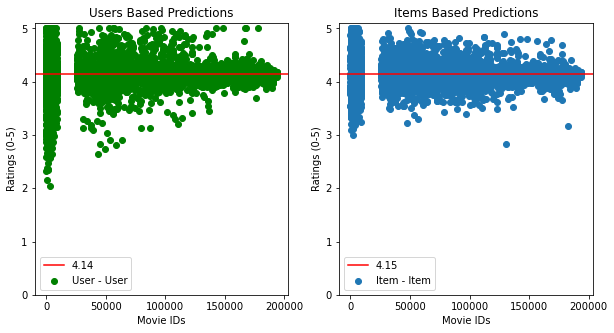

In [18]:
import matplotlib.pyplot as plt
import numpy as np

user_user = hp.user_top_5(user_id = 1, model = knn_baseline, review_df = ratings, movies = movies)        ## The list of movies with the best model
item_item = hp.user_top_5(user_id = 1, model = knn_baseline_item, review_df = ratings, movies = movies)   ## The list of movies with the best model based off items
x_1 = [ID[0] for ID in user_user]   ## All movie id numbers predicted
x_2 = [ID[0] for ID in item_item]   ## All movie id numbers predicted from item based 
y_1 = [ID[1] for ID in user_user]   ## Movie Ratings from user based model
y_2 = [ID[1] for ID in item_item]   ## Movie Ratings from item based model

fig, ax = plt.subplots(ncols= 2, figsize = (10,5))

ax[0].set_title('Users Based Predictions')
ax[0].set_xlabel('Movie IDs')
ax[0].set_ylabel('Ratings (0-5)')
ax[0].set_ylim(0, 5.1)
ax[0].scatter(x_1, y_1, label = 'User - User', color = 'green');
ax[0].axhline(np.mean(y_2), color = 'red',label= round(np.mean(y_1), 2))
ax[0].legend();

ax[1].set_title('Items Based Predictions')
ax[1].set_ylim(0, 5.1)
ax[1].set_ylabel('Ratings (0-5)')
ax[1].set_xlabel('Movie IDs')
ax[1].scatter(x_2, y_2, label = 'Item - Item');
ax[1].axhline(np.mean(y_2), color = 'red', label= round(np.mean(y_2), 2))
ax[1].legend();

### Comparison Analysis
From the predicted ratings for user 1, we can see **a slight difference** in user similarity vs item similarity between movies. Interestingly, the item comparison has all the movies rated above three which goes inside with user 1 trend on rating movies. User 1 doesn't seem so **rate movies lower than three** often and therefore most movies would be rated similarly. Due to the number of users, there is a bigger disparity between users with the movies they watched naturally. 


In [19]:
### Displays the distribution of ratings for the ratings dataset. 
ratings['rating'].loc[ratings['userId'] == 1].value_counts()

5.0    124
4.0     76
3.0     26
2.0      5
1.0      1
Name: rating, dtype: int64

In [20]:
### Print out the results from the models ###

print('Movies from User Filter')
for item in user_user[0:5]:
    print(movies['title'].loc[movies['movieId'] == item[0]].values)
print('Movies from Movie Filter')
for item in item_item[0:5]:
    print(movies['title'].loc[movies['movieId'] == item[0]].values)

Movies from User Filter
['Hoop Dreams (1994)']
['Three Colors: White (Trzy kolory: Bialy) (1994)']
['Shawshank Redemption, The (1994)']
['In the Name of the Father (1993)']
['Wallace & Gromit: The Best of Aardman Animation (1996)']
Movies from Movie Filter
['Shawshank Redemption, The (1994)']
['Ghost in the Shell (Kôkaku kidôtai) (1995)']
['Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)']
['Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)']
['Cool Hand Luke (1967)']


In [92]:
pred_user_1 = hp.user_top_5(knn_baseline, ratings, 1, movies)
user_suggestions = get_genres([ID[0] for ID in pred_user_1], movies)
movie_index = []
for index, suggestion in enumerate(user_suggestions):
    if suggestion in user_1_top_genres:
        movie_index.append(index - 1)
    if len(movie_index) == 5:
        break
top_movie_genre = [pred_user_1[value][0] for value in movie_index]
hp.id_title(top_movie_genre, movies)

596     Ghost in the Shell (Kôkaku kidôtai) (1995)
681                     Singin' in the Rain (1952)
711                               Notorious (1946)
8995                                Sicario (2015)
9162                         Big Short, The (2015)
Name: title, dtype: object

## Next Step
We created two models to help with filtering out the movies.
One recommended movies based on the **similarities of the users** and how they rated other movies. The second recommends movies based on the **similarities of movies** that the users have seen and rated them. 

My first attempt was to use a ranking system based on their position in the list to both of the lists. Then the sum of that rank is taken and the lowest values were suggested to user 1. 

In [21]:
final_df = hp.create_ranked_df(user_user, item_item, movies)
final_df['Movie Id'][0:5].values

array(['Shawshank Redemption, The (1994)',
       'Ghost in the Shell (Kôkaku kidôtai) (1995)',
       'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)',
       'Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)',
       'Boot, Das (Boat, The) (1981)'], dtype=object)

## Different Approachs
Assuming that the two models combined will give a better accuracy than model individually, we can make a rating system that takes the average of the two ratings and potentially get a close rating for the test set from before. 

Another approach was to use content filtering and use the users previous prefered genres from the movies they rated highly on. Their is no way to know that a user would like them, but we can assume that a user would like similar genres over others listed. 

In [93]:
ids = [id[0] for id in sorted(user_user, key= lambda x:x[0])]

rate_1 = np.array([user[1] for user in sorted(user_user, key= lambda x:x[0])])
rate_2 = np.array([item[1] for item in sorted(item_item, key= lambda x:x[0])])

rate_comb = (rate_1 + rate_2)/2
                   
rated_df = pd.DataFrame(zip(ids, rate_comb), columns= ['Movie_ID', 'Combined_Rating'])     
hp.id_title(rated_df.sort_values('Combined_Rating', ascending= False)[0:5]['Movie_ID'].values, movies).values

array(['Shawshank Redemption, The (1994)',
       'Ghost in the Shell (Kôkaku kidôtai) (1995)',
       'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)',
       'High Noon (1952)',
       'Lord of the Rings: The Fellowship of the Ring, The (2001)'],
      dtype=object)

### Individual Results 
The **Top movies** for these methods are as followed

| Weighted Ranks Sum | Average Ratings Movies | Includes Favorite Genres |
|:---:|:---:|:---:|
| **'Shawshank Redemption, The (1994)'** | **'Shawshank Redemption, The (1994)'** | **Ghost in the Shell (Kôkaku kidôtai) (1995)** |
| **'Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)'** | **'Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)'** | Singin' in the Rain (1952) |
| **'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)'** | **'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)'** | Notorious (1946) |
| **'Ghost in the Shell (Kôkaku kidôtai) (1995)'** | 'Lord of the Rings: The Fellowship of the Ring, The (2001)' | Sicario (2015) |
| 'Wallace & Gromit: The Best of Aardman Animation (1996)' | 'High Noon (1952)' | Big Short, The (2015) |

Some similar movies were suggested but there is no way to tell whether a user would like the recommendation that was created. <br> 
**The weighted ranked** recommendations consider all the movies and their respective ranking to give a **more diverse spread**. <br> 
**The average ratings** make sure that **only highly rated movies** are shown as a recommendation from the prediction ratings. <br> 
Using their **favorite genre** can filter out movies they wouldn't normally watch with ones that they are **familiar** with. 

In [16]:
### Cases ###
# 1. A new user is detected and display top 5 movies from the current ratings. 
# Does not use model since there is nothing to go off from 
# user_top_5(review_df= ratings)

# 2. User exist and have movies watched
# Return the list of movies with the ranking. 
top_5_1 = hp.user_top_5(knn_baseline,ratings, user_id = 3, movies= movies)
top_5_1_title = hp.id_title([ID[0] for ID in top_5_1[0:5]], movies)

# 3. User exist and have movies watched
# Return the list of movies with the ranking. 
top_5_593 = hp.user_top_5(knn_baseline,ratings, user_id = 593, movies= movies)
top_5_593_title = hp.id_title([ID[0] for ID in top_5_593[0:5]], movies)

top_5_1_title, top_5_593_title

(254     Léon: The Professional (a.k.a. The Professiona...
 257                                   Pulp Fiction (1994)
 1939                                   Matrix, The (1999)
 2226                                    Fight Club (1999)
 3141                                       Memento (2000)
 Name: title, dtype: object,
 585     Wallace & Gromit: The Best of Aardman Animatio...
 883                                 Paths of Glory (1957)
 1725                                     Happiness (1998)
 2582                  Guess Who's Coming to Dinner (1967)
 3087        In the Mood For Love (Fa yeung nin wa) (2000)
 Name: title, dtype: object)

### Final Movies Recommendation 
Some of the movies were in the top movies list in their list of movies. Based on the ratings and rank we given, some movies was movies were movied up and down which ideally give the best movies to user 1. 

In [26]:
from sklearn.metrics import mean_squared_error
mean_squared_error(actual, pred_combined, squared= False)

0.8715940464071135

### All Model Results 
Comparing all the models, there is a slight improvement in the RSME score with the combined ratings of the item and user models.

|            | **Knn_Baseline_user** | **Knn_Baseline_item** | **Combined Rating** |
|------------|:---------------------:|:---------------------:|:-------------------:|
| RSME Score | .8776                 | .8899                 | **.8708**           |

### Examples
Test cases on new users and new movies to handle cold starts and add new movies whenever a user is reviewing a new movie. 

**Case 1:** A new user wants recommendation to start watching movies <br>
**Results:** Recommends the top average movie tiltes from all ratings

A **new user** with a invalid user ID or no given ID will be recommended **5 of the top movies**. 

**Case 2:** A user rated an existing movie in the list <br>
**Results:** Add a rating in the 'Ratings' dataset with the user ID, Movid Id and rating.

**User 11** reviews the movie ID, **1**, with the rating of **4.5**. 

In [27]:
new_review = {'user_id': 11, 'movie_id': 1 , 'rating': 4.5}
new_df, new_movies = hp.add_review(new_review, ratings,movies)
new_df.tail()

,userId,movieId,rating
100832,610.0,168248.0,5.0
100833,610.0,168250.0,5.0
100834,610.0,168252.0,5.0
100835,610.0,170875.0,3.0
100836,11.0,1.0,4.5


**Case 3:** A new user rated an existing movie in the list
Results: Give the user a new ID and add a rating in the 'Ratings' dataset with the user ID, Movid Id and rating.

A **new user** is assigned a new ID number and rate thhe movie, **304** with a rating **3.0**

In [28]:
new_review = {'user_id': None, 'movie_id': 304, 'title':None , 'genre':None, 'rating': 3.0}
new_df, new_movies = hp.add_review(new_review, ratings,movies)
new_df.tail()

New user number assignment: 611


,userId,movieId,rating
100832,610.0,168248.0,5.0
100833,610.0,168250.0,5.0
100834,610.0,168252.0,5.0
100835,610.0,170875.0,3.0
100836,611.0,304.0,3.0


**Case 4:** A user rated a new movie in the list <br>
**Results:** Add a new movie ID, title and genre to the movies list and add a rating in the 'Ratings' dataset with the user ID, new Movid Id and rating.

**User 501** wants to add a **new movie** with the rating of **1.0**

In [29]:
new_review = {'user_id': 501, 'movie_id': None, 'title': 'Movie Example Movie' , 'genre':'Action', 'rating': 1.0}
new_df, new_movies = hp.add_review(new_review, ratings,movies)
new_df.tail()
new_movies.tail()

,movieId,title,genres
9738,193583,No Game No Life: Zero (2017),animation|comedy|fantasy
9739,193585,Flint (2017),drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),action|animation
9741,193609,Andrew Dice Clay: Dice Rules (1991),comedy
9742,193610,Movie Example Movie,Action


**Case 5:** A new user rated a new movie in the list <br>
**Results:** Give the user a new ID, add a new movie ID, title and genre to the movies list and add a rating in the 'Ratings' dataset with the new user ID, new Movid Id and rating.

In [30]:
new_review = {'user_id': None, 'movie_id': None, 'title': 'Movie Example Movie v2' , 'genre':'Action', 'rating': 1.0}
new_df, new_movies = hp.add_review(new_review, ratings,movies)
display(new_df.tail(), new_movies.tail())

New user number assignment: 611


,userId,movieId,rating
100832,610.0,168248.0,5.0
100833,610.0,168250.0,5.0
100834,610.0,168252.0,5.0
100835,610.0,170875.0,3.0
100836,611.0,193610.0,1.0


,movieId,title,genres
9738,193583,No Game No Life: Zero (2017),animation|comedy|fantasy
9739,193585,Flint (2017),drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),action|animation
9741,193609,Andrew Dice Clay: Dice Rules (1991),comedy
9742,193610,Movie Example Movie v2,Action


## Limitations
This model isn't without its limitations as several aspects make the model less effective.

1. The distrubition is **skewed to the left** with many of the ratings are higher than 3 with **few rated between 0 - 2.5**. This can be contributed to the fact that many people won't leave reviews unprompted.
2. The model doesn't have anything to combat review bombing which has happened to many movies recently to **negatively impact the movie's performance**. This can be difficult since it's hard to distinguish between actually truthful ratings or not. 
3. There were **many ratings from the same users**. There can be a **bias** between users especially when the majority of the ratings are from them. These users could also be critics that may be very helpful to the average moviegoer. 

## Recommendations
There are also some ways to improve the model that can be added to the project to further the accuracy for users.

1. The movie dataset had genres as a column. A previous project shows that **certain combinations perform better at the box office**. If we can incorporate this in the model and know what the users' favorite genres are. 
2. **More data will improve the model**. There was a bigger dataset that was also created and could be used, with enough time, for a better model. 
3. The data should include more ratings with a **wider range of ratings** from the users. Ideally should be a bell curve depending on if an equal number of bad and good movies are included in the movies list. 

## Cold Starts
There are 2 cold starts scienoi when dealing with recommendation systems.
If a new user is added to the system, how would the system suggest recommendations. 
If a new movie is added to the system, how would the system suggest the movie to users. 

For a new user, we can recommend them with the highest rated movie or the most rated movie to be recommended. We can also have the user give more information such as a know movie they watched and that rating or a given genre that the user likes. For this project, I can recommend the most rated movie, or the most review movie. Each have there advantage and disadvange and have there uses if label properly on websites.  

In [31]:
## Recommend the most rated movies without any distinguish ## 
hp.user_top_5(movies= movies, review_df= ratings)
## OR ## 

## Recommend the most reviewed movies from all of the avaiable users currently ## 
movies[movies['movieId'].isin(ratings[['movieId', 'userId']].groupby('movieId').count().sort_values('userId', ascending = False).index[0:5])]['title']

New User Detected. Average top rated movies are as followed


7656    Paper Birds (Pájaros de papel) (2010)
8107               Act of Killing, The (2012)
9083                          Jump In! (2007)
9094                             Human (2015)
9096                      L.A. Slasher (2015)
Name: title, dtype: object

257                  Pulp Fiction (1994)
277     Shawshank Redemption, The (1994)
314                  Forrest Gump (1994)
510     Silence of the Lambs, The (1991)
1939                  Matrix, The (1999)
Name: title, dtype: object

| Most Rated Movies | Most Popular Movies |
|---|---|
| Paper Birds (Pájaros de papel) (2010) | Pulp Fiction (1994) |
| Act of Killing, The (2012) | Shawshank Redemption, The (1994) |
| Jump In! (2007) | Forrest Gump (1994) |
| Human (2015) | Silence of the Lambs, The (1991) |
| L.A. Slasher (2015) | Matrix, The (1999) |

For a new movie, we need to implement the movie in the system and be able to recommend it to users. 
We will use the movies dataset to help decide the rating for the movie and if is should be rated. In order to compare other movies, we used their genres to obtain a average rating. 

New Movie

In [32]:
hp.new_movie('action', movies, ratings)

Genre Detected: action


2.935483870967742

In [33]:
movies.loc[movies['movieId'].isin(ratings.loc[ratings['userId'] == 1]['movieId'].values)]['genres'].value_counts()[0:5]

action|adventure|sci-fi      11
comedy                       11
action|adventure|thriller     8
action|drama|war              8
comedy|drama                  6
Name: genres, dtype: int64

In [49]:
def get_genres(id_list, movies_list):
    '''
    Grab genres from a list of movie IDs and return the unique list of genres
    ______________________________
    Input - id_list (list) 
          - movies_list (Dataframe) 
    Output - list (list) 
    ______________________________
    '''
    return movies_list.loc[movies_list['movieId'].isin(id_list)].genres.unique()

In [52]:
user_1_top_genres = get_genres(ratings.loc[ratings['userId']==1].sort_values('rating', ascending = False)[0:5]['movieId'].values, movies)

In [53]:
user_1_top_genres

array(['action|adventure', 'drama|musical', 'adventure|fantasy',
       'action|adventure|thriller', 'comedy|drama|war'], dtype=object)

596     Ghost in the Shell (Kôkaku kidôtai) (1995)
681                     Singin' in the Rain (1952)
711                               Notorious (1946)
8995                                Sicario (2015)
9162                         Big Short, The (2015)
Name: title, dtype: object